<a href="https://colab.research.google.com/github/Leviathan-Levi/NeuroAI/blob/main/tutorials/W2D2_NeuroSymbolicMethods/student/W2D2_Tutorial2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Tutorial 2: Learning with structure

**Week 2, Day 2: Neuro-Symbolic Methods**

**By Neuromatch Academy**

__Content creators:__ P. Michael Furlong, Chris Eliasmith

__Content reviewers:__ Hlib Solodzhuk, Patrick Mineault, Aakash Agrawal, Alish Dipani, Hossein Rezaei, Yousef Ghanbari, Mostafa Abdollahi

__Production editors:__ Konstantine Tsafatinos, Ella Batty, Spiros Chavlis, Samuele Bolotta, Hlib Solodzhuk


___


# Tutorial Objectives

*Estimated timing of tutorial: 50 minutes*

This tutorial will present you with a couple of play-examples on the usage of basic operations of vector symbolic algebras while generalizing to the new knowledge.

In [ ]:
# @title Tutorial slides
# @markdown These are the slides for the videos in all tutorials today

from IPython.display import IFrame
link_id = "2szmk"

print(f"If you want to download the slides: 'https://osf.io/download/{link_id}'")

IFrame(src=f"https://mfr.ca-1.osf.io/render?url=https://osf.io/download/{link_id}/?direct%26mode=render", width=854, height=480)

---
# Setup



In [1]:
# @title Install and import feedback gadget

!pip install --quiet numpy matplotlib ipywidgets scipy scikit-learn vibecheck

from vibecheck import DatatopsContentReviewContainer
def content_review(notebook_section: str):
    return DatatopsContentReviewContainer(
        "",  # No text prompt
        notebook_section,
        {
            "url": "https://pmyvdlilci.execute-api.us-east-1.amazonaws.com/klab",
            "name": "neuromatch_neuroai",
            "user_key": "wb2cxze8",
        },
    ).render()


feedback_prefix = "W2D2_T2"

  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 12.0 MB/s eta 0:00:00


In [2]:
# @title Install dependencies

# Install sspspace
!pip install git+https://github.com/ctn-waterloo/sspspace@neuromatch --quiet

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.5/12.5 MB 70.7 MB/s eta 0:00:00


In [3]:
# @title Imports

#working with data
import numpy as np

#plotting
import matplotlib.pyplot as plt
import logging

#interactive display
import ipywidgets as widgets

#modeling
import sspspace
from scipy.special import softmax
from sklearn.metrics import log_loss
from sklearn.neural_network import MLPRegressor

In [4]:
# @title Figure settings

logging.getLogger('matplotlib.font_manager').disabled = True

%matplotlib inline
%config InlineBackend.figure_format = 'retina' # perfrom high definition rendering for images and plots
plt.style.use("https://raw.githubusercontent.com/NeuromatchAcademy/course-content/main/nma.mplstyle")

In [5]:
# @title Plotting functions

def plot_similarity_matrix(sim_mat, labels, values = False):
    """
    Plot the similarity matrix between vectors.

    Inputs:
    - sim_mat (numpy.ndarray): similarity matrix between vectors.
    - labels (list of str): list of strings which represent concepts.
    - values (bool): True if we would like to plot values of similarity too.
    """
    with plt.xkcd():
        plt.imshow(sim_mat, cmap='Greys')
        plt.colorbar()
        plt.xticks(np.arange(len(labels)), labels, rotation=45, ha="right", rotation_mode="anchor")
        plt.yticks(np.arange(len(labels)), labels)
        if values:
            for x in range(sim_mat.shape[1]):
                for y in range(sim_mat.shape[0]):
                    plt.text(x, y, f"{sim_mat[y, x]:.2f}", fontsize = 8, ha="center", va="center", color="green")
        plt.title('Similarity between vector-symbols')
        plt.xlabel('Symbols')
        plt.ylabel('Symbols')
        plt.show()

def plot_training_and_choice(losses, sims, ant_names, cons_names, action_names):
    """
    Plot loss progression over training as well as predicted similarities for given rules / correct solutions.

    Inputs:
    - losses (list): list of loss values.
    - sims (list): list of similartiy matrices.
    - ant_names (list): list of antecedance names.
    - cons_names (list): list of consequent names.
    - action_names (list): full list of concepts.
    """
    with plt.xkcd():
        plt.subplot(1, len(ant_names) + 1, 1)
        plt.plot(losses)
        plt.xlabel('Training number')
        plt.ylabel('Loss')
        plt.title('Training Error')
        index = 1
        for ant_name, cons_name, sim in zip(ant_names, cons_names, sims):
            index += 1
            plt.subplot(1, len(ant_names) + 1, index)
            plt.bar(range(len(action_names)), sim.flatten())
            plt.gca().set_xticks(range(len(action_names)))
            plt.gca().set_xticklabels(action_names, rotation=90)
            plt.title(f'{ant_name}, not*{cons_name}')

def plot_choice(sims, ant_names, cons_names, action_names):
    """
    Plot predicted similarities for given rules / correct solutions.
    """
    with plt.xkcd():
        index = 0
        for ant_name, cons_name, sim in zip(ant_names, cons_names, sims):
            index += 1
            plt.subplot(1, len(ant_names) + 1, index)
            plt.bar(range(len(action_names)), sim.flatten())
            plt.gca().set_xticks(range(len(action_names)))
            plt.gca().set_xticklabels(action_names, rotation=90)
            plt.ylabel("Similarity")
            plt.title(f'{ant_name}, not*{cons_name}')

In [6]:
# @title Set random seed

import random
import numpy as np

def set_seed(seed=None):
  if seed is None:
    seed = np.random.choice(2 ** 32)
  random.seed(seed)
  np.random.seed(seed)

set_seed(seed = 42)

---

# Section 1: Analogies. Part 1

In this section we will construct a simple analogy using Vector Symbolic Algebras. The question we are going to try and solve is "King is to the queen as the prince is to X."

In [ ]:
# @title Video 1: Analogy 1

from ipywidgets import widgets
from IPython.display import YouTubeVideo
from IPython.display import IFrame
from IPython.display import display

class PlayVideo(IFrame):
  def __init__(self, id, source, page=1, width=400, height=300, **kwargs):
    self.id = id
    if source == 'Bilibili':
      src = f'https://player.bilibili.com/player.html?bvid={id}&page={page}'
    elif source == 'Osf':
      src = f'https://mfr.ca-1.osf.io/render?url=https://osf.io/download/{id}/?direct%26mode=render'
    super(PlayVideo, self).__init__(src, width, height, **kwargs)

def display_videos(video_ids, W=400, H=300, fs=1):
  tab_contents = []
  for i, video_id in enumerate(video_ids):
    out = widgets.Output()
    with out:
      if video_ids[i][0] == 'Youtube':
        video = YouTubeVideo(id=video_ids[i][1], width=W,
                             height=H, fs=fs, rel=0)
        print(f'Video available at https://youtube.com/watch?v={video.id}')
      else:
        video = PlayVideo(id=video_ids[i][1], source=video_ids[i][0], width=W,
                          height=H, fs=fs, autoplay=False)
        if video_ids[i][0] == 'Bilibili':
          print(f'Video available at https://www.bilibili.com/video/{video.id}')
        elif video_ids[i][0] == 'Osf':
          print(f'Video available at https://osf.io/{video.id}')
      display(video)
    tab_contents.append(out)
  return tab_contents

video_ids = [('Youtube', '2tR4fHvL1Jk'), ('Bilibili', 'BV1fS411P7Ez')]
tab_contents = display_videos(video_ids, W=854, H=480)
tabs = widgets.Tab()
tabs.children = tab_contents
for i in range(len(tab_contents)):
  tabs.set_title(i, video_ids[i][0])
display(tabs)

In [ ]:
# @title Submit your feedback
content_review(f"{feedback_prefix}_analogy_part_one")

## Coding Exercise 1: Royal Relationships

We're going to start by considering our vocabulary. We will use the basic discrete concepts of monarch, heir, male, and female.

Let's create the objects we know about by combinatorially expanding the space:

1. King is a male monarch
2. Queen is a female monarch
3. Prince is a male heir
4. Princess is a female heir

Complete the missing parts of the code to obtain correct representations of new concepts.

In [7]:
###################################################################
## Fill out the following then remove
#raise NotImplementedError("Student exercise: complete correct relations for creating new concepts.")
###################################################################

set_seed(42)

symbol_names = ['monarch','heir','male','female']
discrete_space = sspspace.DiscreteSPSpace(symbol_names, ssp_dim=1024, optimize=False)

objs = {n:discrete_space.encode(n) for n in symbol_names}

objs['king'] = objs['monarch'] * objs['male']
objs['queen'] = objs['monarch'] * objs['female']
objs['prince'] = objs['heir'] * objs['male']
objs['princess'] = objs['heir'] * objs['female']

[*Click for solution*](https://github.com/neuromatch/NeuroAI_Course/tree/main/tutorials/W2D2_NeuroSymbolicMethods/solutions/W2D2_Tutorial2_Solution_721e11a2.py)



Now, we can take an explicit approach. We know that the conversion from king to queen is to unbind male and bind female, so let's apply that to our prince object and see what we uncover.

At first, in the cell below, let's recover `queen` from `king` by constructing a new `query` concept, which represents the unbinding of `male` and the binding of `female.`

In [8]:
###################################################################
## Fill out the following then remove
#raise NotImplementedError("Student exercise: complete correct relation for creating `query` object to compare with `queen`.")
###################################################################

objs['query'] = (objs['king'] * ~objs['male']) * objs['female']

[*Click for solution*](https://github.com/neuromatch/NeuroAI_Course/tree/main/tutorials/W2D2_NeuroSymbolicMethods/solutions/W2D2_Tutorial2_Solution_f088f722.py)



Let's see if this new query object bears any similarity to anything in our vocabulary.

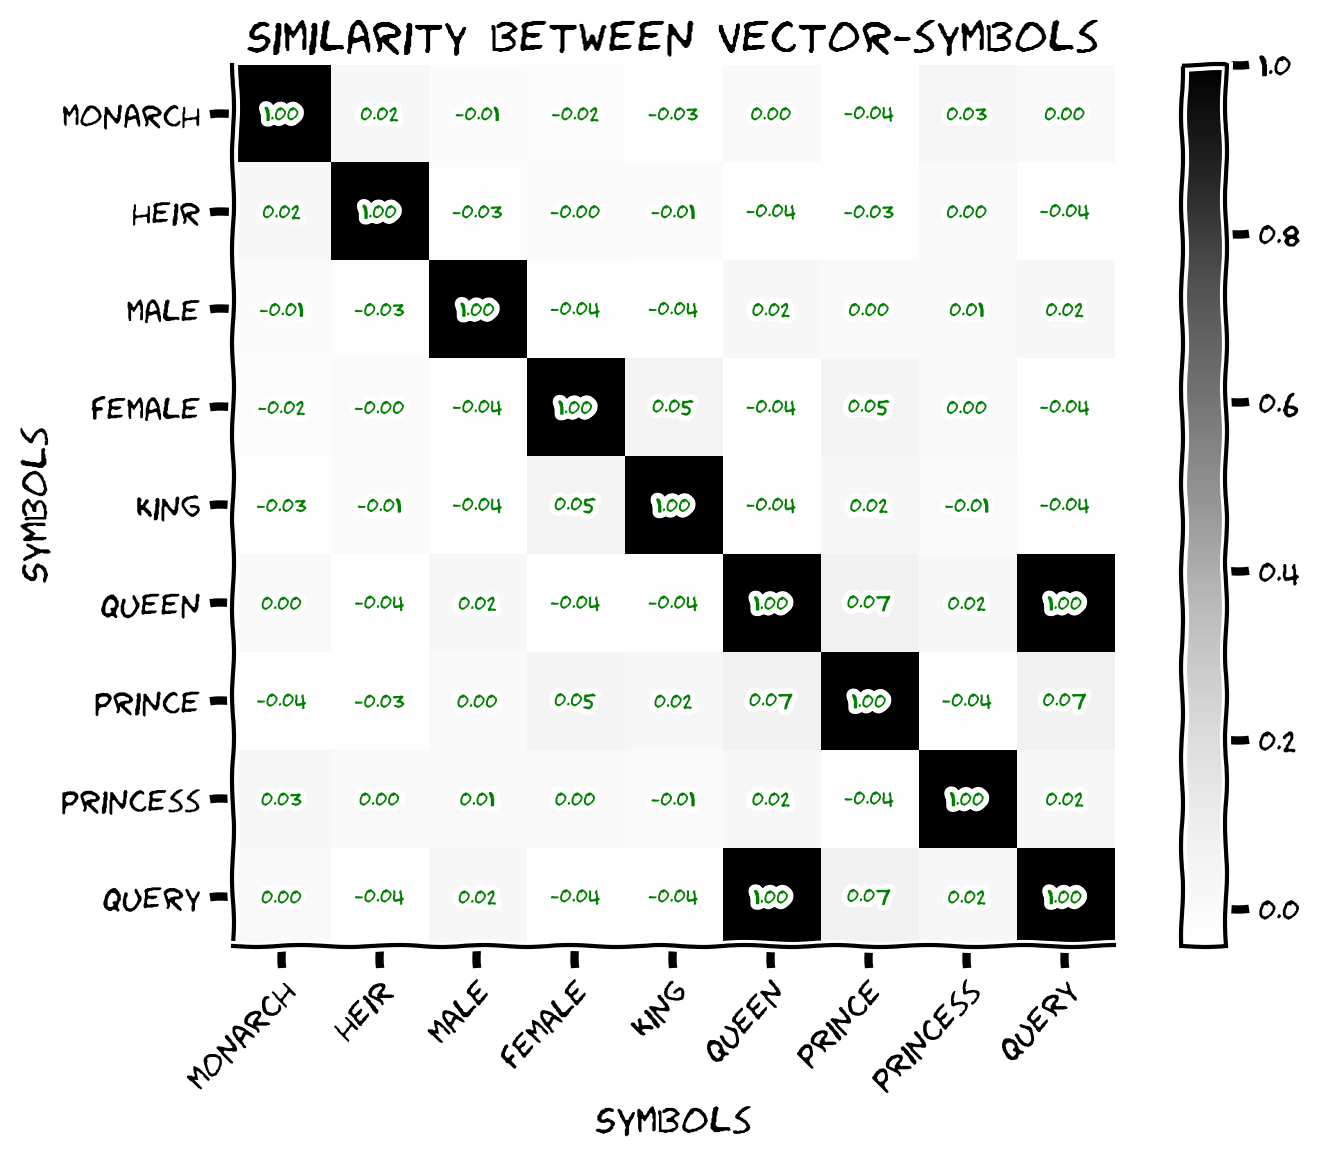

In [9]:
object_names = list(objs.keys())
sims = np.zeros((len(object_names), len(object_names)))

for name_idx, name in enumerate(object_names):
    for other_idx in range(name_idx, len(object_names)):
        sims[name_idx, other_idx] = sims[other_idx, name_idx] = (objs[name] | objs[object_names[other_idx]]).item()

plot_similarity_matrix(sims, object_names, values = True)

The above similarity plot shows that applying that operation successfully converts king to queen. Let's apply it to 'prince' and see what happens. Now, `query` should represent the `princess` concept.

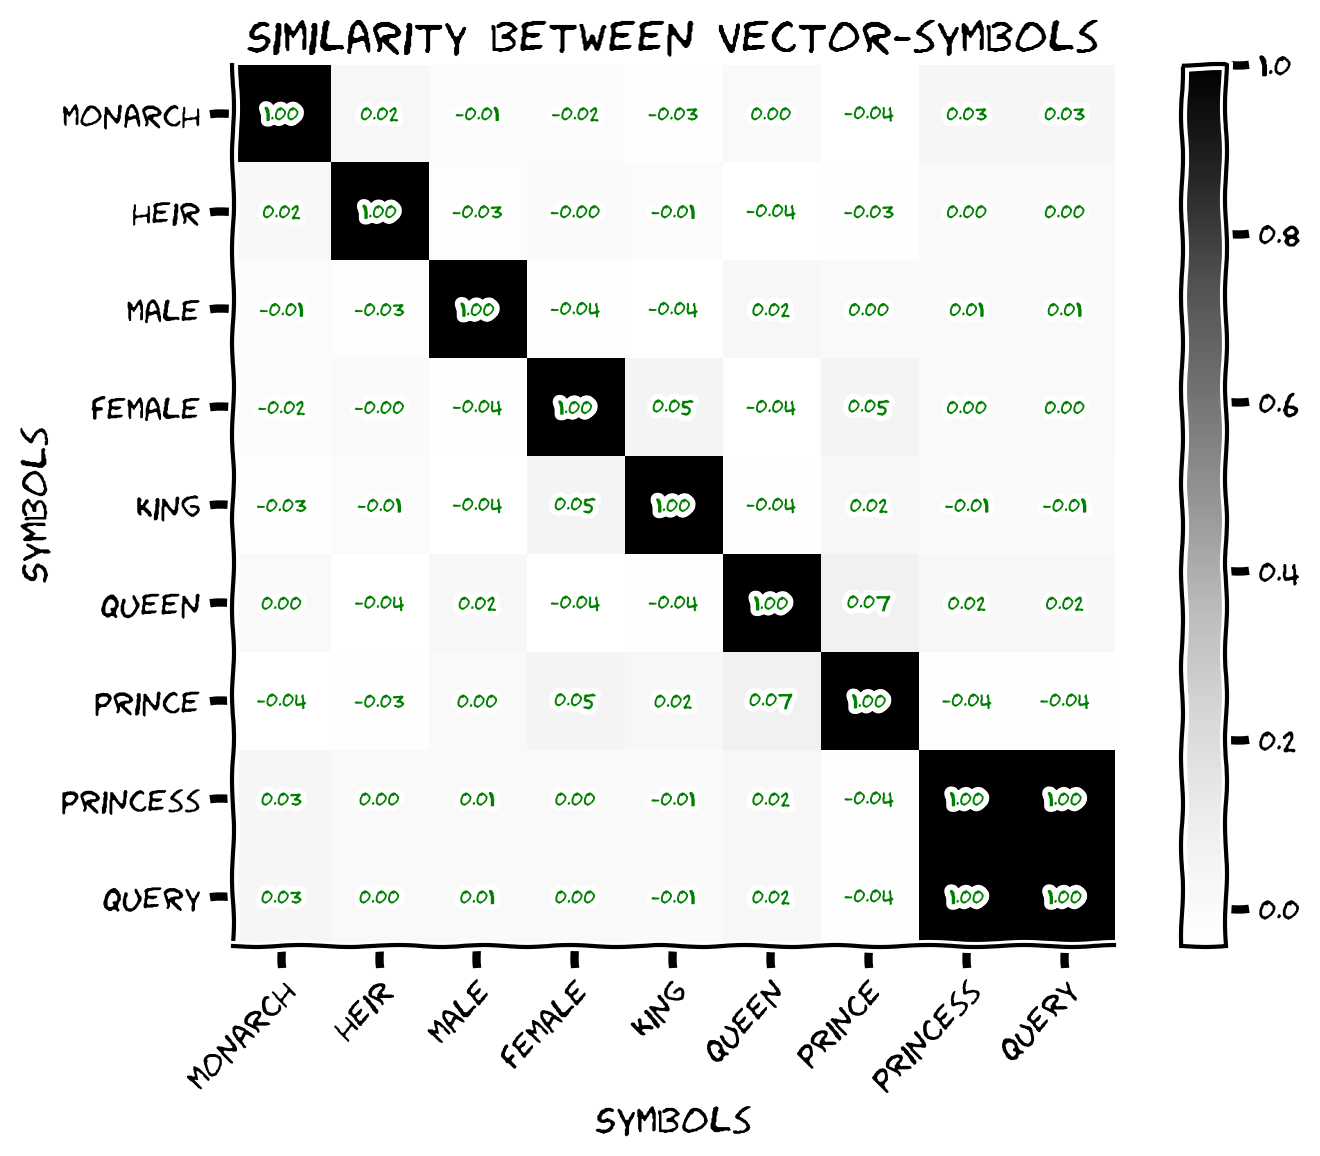

In [10]:
objs['query'] = (objs['prince'] * ~objs['male']) * objs['female']

sims = np.zeros((len(object_names), len(object_names)))

for name_idx, name in enumerate(object_names):
    for other_idx in range(name_idx, len(object_names)):
        sims[name_idx, other_idx] = sims[other_idx, name_idx] = (objs[name] | objs[object_names[other_idx]]).item()

plot_similarity_matrix(sims, object_names, values = True)

Here, we have successfully recovered the princess, completing the analogy.

This approach, however, requires explicit knowledge of the construction of the objects.  Let's see if we can just work with the concepts of 'king,' 'queen,' and 'prince' directly.

In the cell below, construct the `princess` concept using only `king,` `queen`, and `prince.`

In [12]:
###################################################################
## Fill out the following then remove
#raise NotImplementedError("Student exercise: complete correct relation for creating `query` object to compare with `princess`.")
###################################################################

objs['query'] = (objs['prince'] * ~objs['king']) * objs['queen']

[*Click for solution*](https://github.com/neuromatch/NeuroAI_Course/tree/main/tutorials/W2D2_NeuroSymbolicMethods/solutions/W2D2_Tutorial2_Solution_b682d4ac.py)



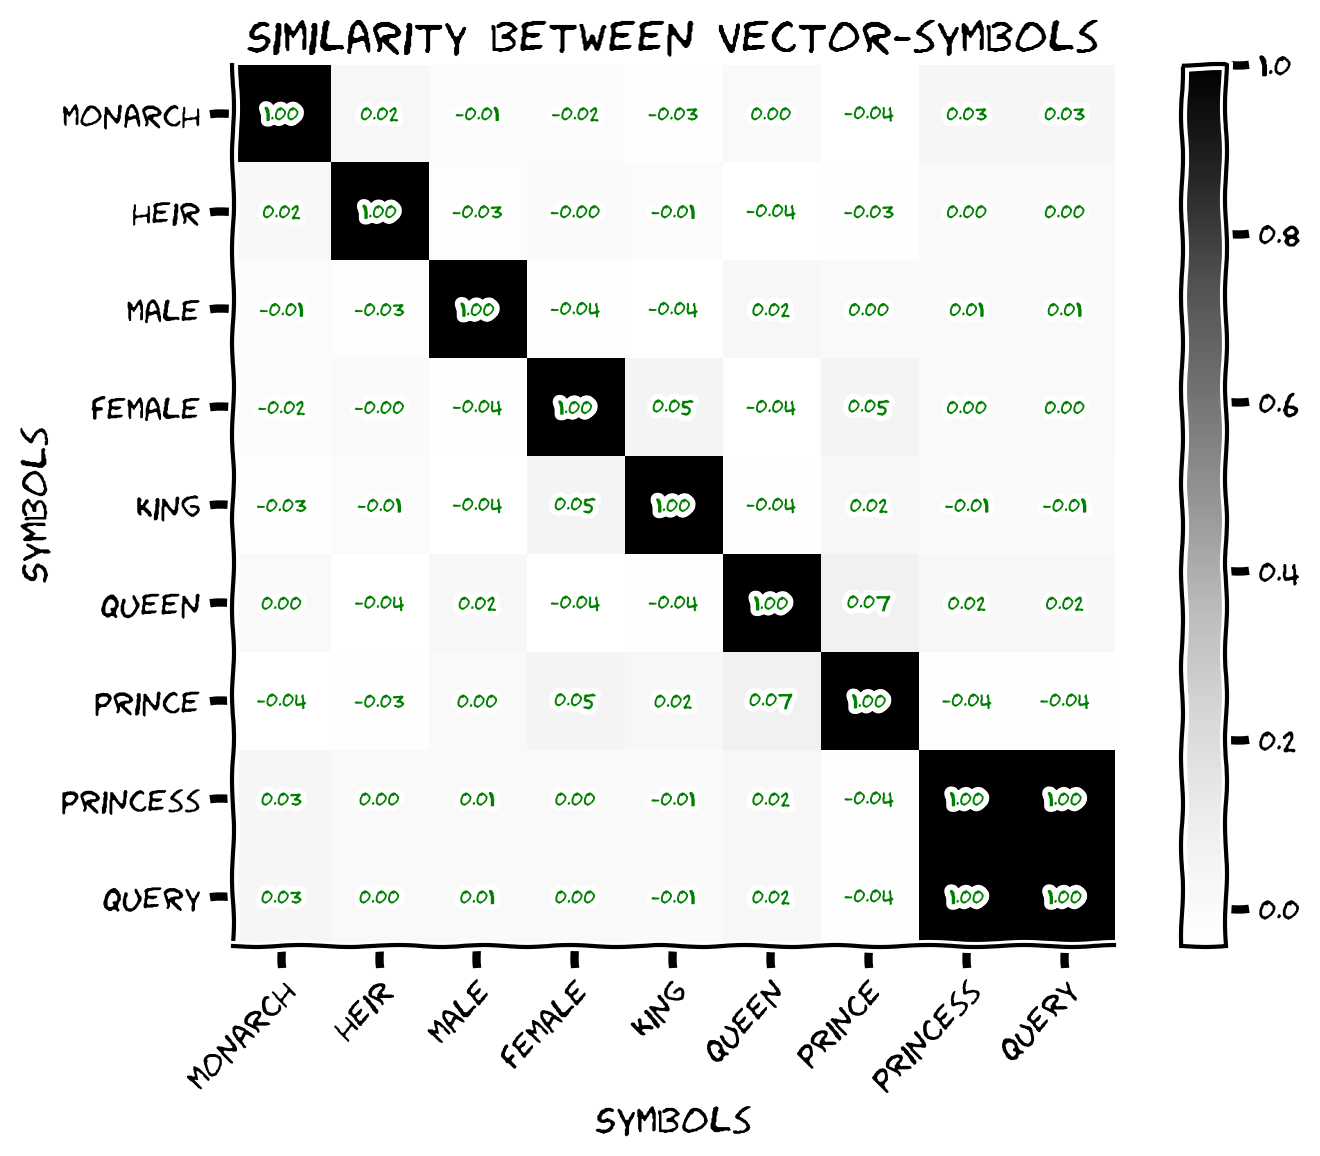

In [13]:
sims = np.zeros((len(object_names), len(object_names)))

for name_idx, name in enumerate(object_names):
    for other_idx in range(name_idx, len(object_names)):
        sims[name_idx, other_idx] = sims[other_idx, name_idx] = (objs[name] | objs[object_names[other_idx]]).item()

plot_similarity_matrix(sims, object_names, values = True)

Again, we see that we have recovered the princess by using our analogy.

That said, the above depends on knowing that the representations are constructed using binding. Can we do something similar through the bundling operation? Let's try that out.

Reassing concept definitions using bundling operation.

In [14]:
objs['king'] = (objs['monarch'] + objs['male']).normalize()
objs['queen'] = (objs['monarch'] + objs['female']).normalize()
objs['prince'] = (objs['heir'] + objs['male']).normalize()
objs['princess'] = (objs['heir'] + objs['female']).normalize()

But now that we are using an additive model, we need to take a different approach. Instead of unbinding the king and binding the queen, we subtract the king and add the queen to find the princess from the prince.

Complete the code to reflect the updated mechanism.

In [15]:
###################################################################
## Fill out the following then remove
#raise NotImplementedError("Student exercise: complete correct relation for creating `query` object to compare with `princess`.")
###################################################################

objs['query'] = (objs['prince'] - objs['king']) + objs['queen']

[*Click for solution*](https://github.com/neuromatch/NeuroAI_Course/tree/main/tutorials/W2D2_NeuroSymbolicMethods/solutions/W2D2_Tutorial2_Solution_a4fe9181.py)



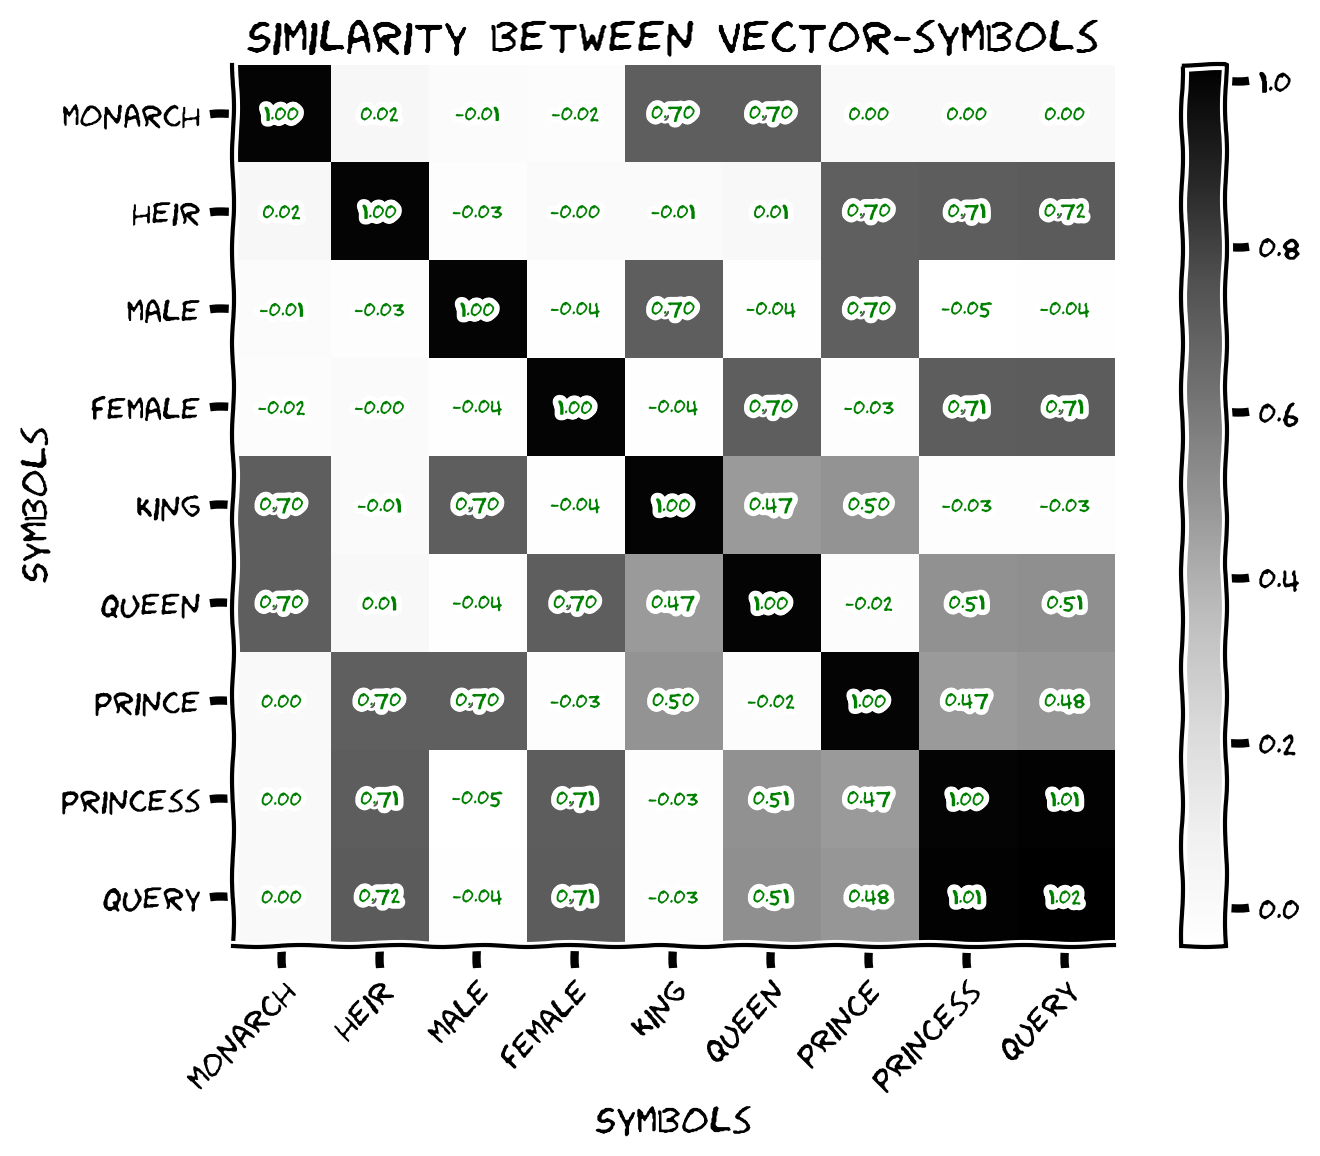

In [16]:
sims = np.zeros((len(object_names), len(object_names)))

for name_idx, name in enumerate(object_names):
    for other_idx in range(name_idx, len(object_names)):
        sims[name_idx, other_idx] = sims[other_idx, name_idx] = (objs[name] | objs[object_names[other_idx]]).item()

plot_similarity_matrix(sims, object_names, values = True)

This is a messier similarity plot due to the fact that the bundled representations interact with all their constituent parts in the vocabulary.  That said, we see that 'princess' is still most similar to the query vector.

This approach is more like what we would expect from a `word2vec` embedding.

In [ ]:
# @title Submit your feedback
content_review(f"{feedback_prefix}_royal_relationships")

---

# Section 2: Analogies. Part 2

Estimated timing to here from start of tutorial: 15 minutes

In this section, we will construct a database of data structures that describe different countries. Materials are adopted from [Kanerva (2010)](https://cdn.aaai.org/ocs/2243/2243-9566-1-PB.pdf).

In [ ]:
# @title Video 2: Analogy 2

from ipywidgets import widgets
from IPython.display import YouTubeVideo
from IPython.display import IFrame
from IPython.display import display

class PlayVideo(IFrame):
  def __init__(self, id, source, page=1, width=400, height=300, **kwargs):
    self.id = id
    if source == 'Bilibili':
      src = f'https://player.bilibili.com/player.html?bvid={id}&page={page}'
    elif source == 'Osf':
      src = f'https://mfr.ca-1.osf.io/render?url=https://osf.io/download/{id}/?direct%26mode=render'
    super(PlayVideo, self).__init__(src, width, height, **kwargs)

def display_videos(video_ids, W=400, H=300, fs=1):
  tab_contents = []
  for i, video_id in enumerate(video_ids):
    out = widgets.Output()
    with out:
      if video_ids[i][0] == 'Youtube':
        video = YouTubeVideo(id=video_ids[i][1], width=W,
                             height=H, fs=fs, rel=0)
        print(f'Video available at https://youtube.com/watch?v={video.id}')
      else:
        video = PlayVideo(id=video_ids[i][1], source=video_ids[i][0], width=W,
                          height=H, fs=fs, autoplay=False)
        if video_ids[i][0] == 'Bilibili':
          print(f'Video available at https://www.bilibili.com/video/{video.id}')
        elif video_ids[i][0] == 'Osf':
          print(f'Video available at https://osf.io/{video.id}')
      display(video)
    tab_contents.append(out)
  return tab_contents

video_ids = [('Youtube', 'OB3hzhM7Ois'), ('Bilibili', 'BV1TZ421g7G5')]
tab_contents = display_videos(video_ids, W=854, H=480)
tabs = widgets.Tab()
tabs.children = tab_contents
for i in range(len(tab_contents)):
  tabs.set_title(i, video_ids[i][0])
display(tabs)

In [ ]:
# @title Submit your feedback
content_review(f"{feedback_prefix}_analogy_part_two")

## Coding Exercise 2: Dollar of Mexico

This is going to be a little more involved because to construct the data structure, we are going to need vectors that not only represent values that we are reasoning about, but also vectors that represent different roles data can play. This is sometimes called a slot-filler representation or a key-value representation.

At first, let us define concepts and cleanup object. Then, we will define `canada` and `mexico` concepts by integrating the available information together. You will be provided with a `canada` object and your task is to complete for `mexico` one. Note that:

* We bind `currency` to the relevant currency for that country (`dollar` for Canada, `peso` for Mexico)
* We bind `capital` to the relevant capital for that country (`Ottawa` for Canada, `Mexico City` for Mexico)

In [17]:
###################################################################
## Fill out the following then remove
#raise NotImplementedError("Student exercise: complete `mexico` concept.")
###################################################################

set_seed(42)

symbol_names = ['dollar', 'peso', 'ottawa', 'mexico-city', 'currency', 'capital']
discrete_space = sspspace.DiscreteSPSpace(symbol_names, ssp_dim=1024, optimize=False)

objs = {n:discrete_space.encode(n) for n in symbol_names}

cleanup = sspspace.Cleanup(objs)

objs['canada'] = ((objs['currency'] * objs['dollar']) + (objs['capital'] * objs['ottawa'])).normalize()
objs['mexico'] = ((objs['currency'] * objs['peso']) + (objs['capital'] * objs['mexico-city'])).normalize()

[*Click for solution*](https://github.com/neuromatch/NeuroAI_Course/tree/main/tutorials/W2D2_NeuroSymbolicMethods/solutions/W2D2_Tutorial2_Solution_a74c3855.py)



We would like to find out Mexico's currency. Complete the code for constructing a `query` which will help us do that. Note that we are using a cleanup operation.

In [18]:
###################################################################
## Fill out the following then remove
#raise NotImplementedError("Student exercise: complete `query` concept which will be similar to currency in Mexico.")
###################################################################

objs['query'] = cleanup(~(objs['canada'] * objs['dollar']) * objs['mexico'])

[*Click for solution*](https://github.com/neuromatch/NeuroAI_Course/tree/main/tutorials/W2D2_NeuroSymbolicMethods/solutions/W2D2_Tutorial2_Solution_f69c6425.py)



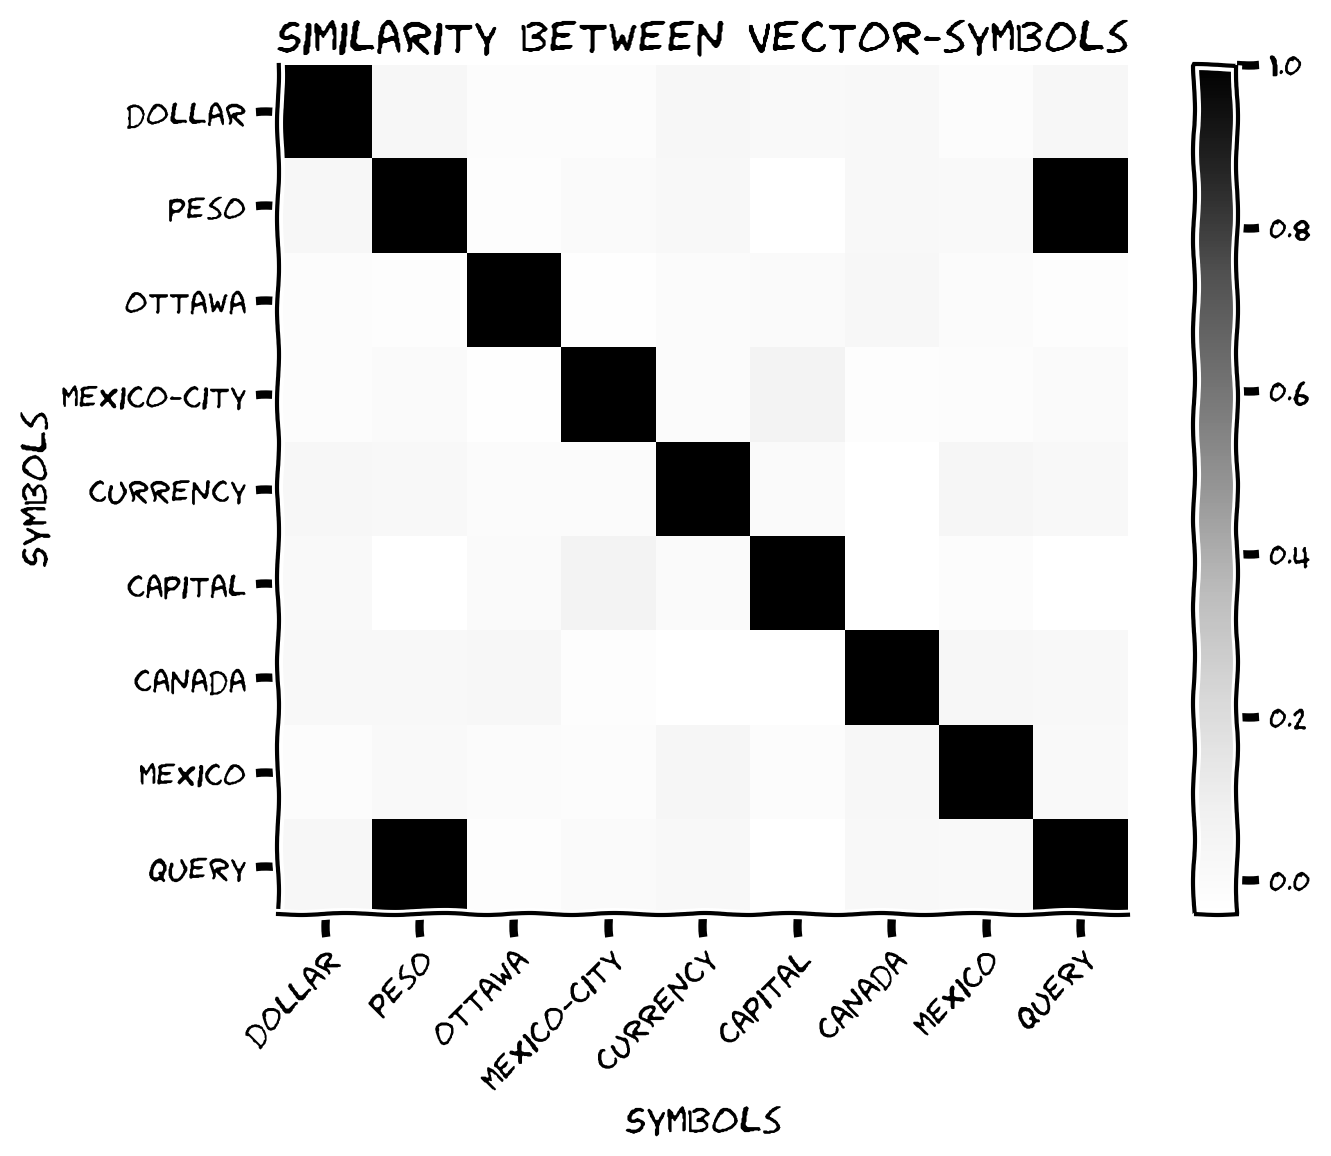

In [19]:
object_names = list(objs.keys())
sims = np.zeros((len(object_names), len(object_names)))

for name_idx, name in enumerate(object_names):
    for other_idx in range(name_idx, len(object_names)):
        sims[name_idx, other_idx] = sims[other_idx, name_idx] = (objs[name] | objs[object_names[other_idx]]).item()

plot_similarity_matrix(sims, object_names)

After cleanup, the query vector is the most similar to the `peso` object in the vocabulary, correctly answering the question.  

Note, however, that the similarity is not perfectly equal to 1. This is due to the scale factors applied to the composite vectors `canada` and `mexico`, to ensure they remain unit vectors, and due to cross talk. Crosstalk is a symptom of the fact that we are binding and unbinding bundles of vector symbols to produce the resultant query vector. The constituent vectors are not perfectly orthogonal (i.e., having a dot product of zero), and as such, the terms in the bundle interact when we measure similarity between them.

In [ ]:
# @title Submit your feedback
content_review(f"{feedback_prefix}_dolar_of_mexico")

---

# Section 3: Wason Card Task

Estimated timing to here from start of tutorial: 25 minutes

One of the powerful benefits of using these structured representations is being able to generalize to other circumstances. To demonstrate this, we are going to show you this in a simple task.

In [ ]:
# @title Video 3: Wason Card Task Intro

from ipywidgets import widgets
from IPython.display import YouTubeVideo
from IPython.display import IFrame
from IPython.display import display

class PlayVideo(IFrame):
  def __init__(self, id, source, page=1, width=400, height=300, **kwargs):
    self.id = id
    if source == 'Bilibili':
      src = f'https://player.bilibili.com/player.html?bvid={id}&page={page}'
    elif source == 'Osf':
      src = f'https://mfr.ca-1.osf.io/render?url=https://osf.io/download/{id}/?direct%26mode=render'
    super(PlayVideo, self).__init__(src, width, height, **kwargs)

def display_videos(video_ids, W=400, H=300, fs=1):
  tab_contents = []
  for i, video_id in enumerate(video_ids):
    out = widgets.Output()
    with out:
      if video_ids[i][0] == 'Youtube':
        video = YouTubeVideo(id=video_ids[i][1], width=W,
                             height=H, fs=fs, rel=0)
        print(f'Video available at https://youtube.com/watch?v={video.id}')
      else:
        video = PlayVideo(id=video_ids[i][1], source=video_ids[i][0], width=W,
                          height=H, fs=fs, autoplay=False)
        if video_ids[i][0] == 'Bilibili':
          print(f'Video available at https://www.bilibili.com/video/{video.id}')
        elif video_ids[i][0] == 'Osf':
          print(f'Video available at https://osf.io/{video.id}')
      display(video)
    tab_contents.append(out)
  return tab_contents

video_ids = [('Youtube', 'BAju3MNHCq8'), ('Bilibili', 'BV1Qf421X7MB')]
tab_contents = display_videos(video_ids, W=854, H=480)
tabs = widgets.Tab()
tabs.children = tab_contents
for i in range(len(tab_contents)):
  tabs.set_title(i, video_ids[i][0])
display(tabs)

In [ ]:
# @title Submit your feedback
content_review(f"{feedback_prefix}_wason_card_task_intro")

## Coding Exercise 3: Wason Card Task

We are going to test the generalization property on the Wason Card Task, where a person is told a rule of the form "if the card is even, then the back is blue", they are then presented with a number of cards with either an odd number, an even number, a red back, or a blue back. The participant is asked which cards they have to flip to determine that the rule is true.

In this case, the participant needs to flip only the even card(s), and any card where the back is not blue, as the rule does not state whether or not odd numbers can have blue backs, and a red-backed card with an even number would violate the rule. We can get this from Boolean logic:

$$
\mathrm{even} \implies \mathrm{blue}
$$

which is equal to

$$
\neg \mathrm{even} \wedge \mathrm{blue}
$$

where $\neg$ means a logical not and $\wedge$ means logical and. If we want to find cards that violate the rule, then we negate the rule, providing:

$$
\neg (\neg \mathrm{even} \wedge \mathrm{blue}) = \mathrm{even} \vee \neg \mathrm{blue}.
$$

Where $\vee$ is the logical or. Hence, the cards that can violate the rule are either even or not blue.  

At first, we will define all the needed concepts. For all noun concepts, we would also like to have `not concept` presented in the space; please complete missing code parts.

1. 根据逻辑，even ⟹ blue 等价于 ¬even ∨ blue。

2. 为了找到违反规则的卡片，我们需要否定这个规则：

规则的否定：¬(even ⟹ blue)

因为 even ⟹ blue 等价于 ¬even ∨ blue，所以规则的否定是：
¬(¬even ∨ blue)
3. 应用德摩根定律

使用德摩根定律，我们可以将规则的否定进一步简化：
¬(¬even∨blue)=even∧¬blue

4. 所以，违反规则的卡片是：

偶数且不是蓝色 (even ∧ ¬blue)
因此，参与者需要翻转：

所有偶数卡片（验证这些卡片的背面是否是蓝色）

所有背面不是蓝色的卡片（验证这些卡片的正面是否是偶数）

In [20]:
set_seed(42)

card_states = ['red','blue','odd','even','not','green','prime','implies','ant','relation','cons']
encoder = sspspace.DiscreteSPSpace(card_states, ssp_dim=1024, optimize=False)
vocab = {c:encoder.encode(c) for c in card_states}#创建了一个字典vocab，其中每个键是card_states中的一个状态，每个值是使用encoder.encode(c)方法获得的对应编码。简单来说，这个字典将每个状态映射到其语义指针空间表示。

###################################################################
## Fill out the following then remove
#raise NotImplementedError("Student exercise: complete creating `not x` concepts.")
###################################################################

for a in ['red','blue','odd','even','green','prime']:
    vocab[f'not*{a}'] = vocab['not'] * vocab[a]#为状态列表中的每个状态生成了带有前缀not*的新条目。对于列表中的每个状态a，它计算一个新的编码，通过将'not'的编码与状态a的编码相乘（*），在语义指针空间中，这种乘法通常表示逻辑或组合上的结合。

action_names = ['red','blue','odd','even','green','prime','not*red','not*blue','not*odd','not*even','not*green','not*prime']#定义了一个包含原始状态和之前步骤中新创建的组合状态的动作名称列表。
action_space = np.array([vocab[x] for x in action_names]).squeeze()
#创建了一个NumPy数组，其内容是这些动作名称在vocab字典中的语义指针空间表示。具体来说：
##[vocab[x] for x in action_names]从vocab字典中获取每个动作名称的编码向量。
##np.array(...)将这些向量转换为一个NumPy数组。
##.squeeze()用于去除数组中所有单维度的条目，确保action_space的形状正确。

[*Click for solution*](https://github.com/neuromatch/NeuroAI_Course/tree/main/tutorials/W2D2_NeuroSymbolicMethods/solutions/W2D2_Tutorial2_Solution_47654e2f.py)



Now, we are going to set up a simple perceptron-style learning rule using the HRR (Holographic Reduced Representations) algebra. We are going to learn a target transformation, $T$, such that given a learning rule, $A^{*} = T\circledast R$. Here:

* $R$ is the rule to be learned
* $A^{*}$ is the antecedent value bundled with $\texttt{not}$ bound with the consequent value. This is because we are trying to learn the cards that can *violate* the rule.

Rules themselves are going to be composed like the data structures representing different countries in the previous section. `ant,` `relation`, and `cons` are extra concepts that define the structure and which will bind to the specific instances.

If we have a rule, $X \implies Y$, then we would create the VSA representation:

$$ R = \texttt{ant} \circledast X + \texttt{relation} \circledast \texttt{implies} + \texttt{cons} \circledast Y $$

and the ideal output is:

$$
A^{*} = X + \texttt{not}\circledast Y
$$

In the cell below, let us define two rules:

$$\text{blue} \implies \text{even}$$
$$\text{odd} \implies \text{green}$$

In [21]:
###################################################################
## Fill out the following then remove
#raise NotImplementedError("Student exercise: complete creating rules as defined above.")
###################################################################

rules = [
    (vocab['ant'] * vocab['blue'] + vocab['relation'] * vocab['implies'] + vocab['cons'] * vocab['even']).normalize(),
    (vocab['ant'] * vocab['odd'] + vocab['relation'] * vocab['implies'] + vocab['cons'] * vocab['green']).normalize(),
]

[*Click for solution*](https://github.com/neuromatch/NeuroAI_Course/tree/main/tutorials/W2D2_NeuroSymbolicMethods/solutions/W2D2_Tutorial2_Solution_150dc068.py)



Now, we are ready to derive the transformation! For that, we will iterate through the rules and solutions for a specified number of iterations and update it as the following:

$$ T \leftarrow T - \text{lr} (T - A^{} \circledast \sim R)$$

where $\text{lr}$ is learning rate constant value. Ultimately, we want $A^{*} = T\circledast R$, so we unbind $R$ to recover the desired transform and use the learning rule to update our current estimated transform.

We will also compute loss progression over time and log the loss function between perfect similarity (ones only for antecedence value and not consequent one) and the one we obtain between prediction for current transformation and full action space. Complete the missing parts of the code in the next cell to complete training.

T：当前的变换或模型参数。这个是我们希望通过优化过程来更新的目标。

lr：学习率（Learning Rate），是一个超参数，用于控制每次更新的步长或速度。学习率决定了在每一步更新中，变换（
𝑇
T）改变的幅度。

A：目标变换或参考值，这个值通常表示理想情况下的结果或目标。

∼R：表示对
𝑅
R 取反。这里的
𝑅
R 可能是表示实际结果或某种状态，
∼
∼ 代表逻辑上的取反（negation）。

⊙：表示逐元素乘法（Hadamard product），即对两个矩阵或向量的每个对应元素进行乘法操作。


T−A⊙∼R：这个表达式计算了当前变换
𝑇
T 与目标
𝐴
⊙
∼
𝑅
A⊙∼R 之间的差距或误差。


T−lr⋅(T−A⊙∼R)：这个公式表示通过减去误差（乘以学习率）来更新当前变换
𝑇
T，以便逐步优化目标。

In [22]:
###################################################################
## Fill out the following then remove
#raise NotImplementedError("Student exercise: complete training loop.")
###################################################################

num_iters = 500
losses = []
sims = []
lr = 1e-1
ant_names = ["blue", "odd"]
cons_names = ["even", "green"]

transform = np.zeros((1,encoder.ssp_dim))
for i in range(num_iters):
    loss = 0
    for rule, ant_name, cons_name in zip(rules, ant_names, cons_names):

        #perfect similarity
        y_true = np.eye(len(action_names))[action_names.index(ant_name),:] + np.eye(len(action_names))[4+action_names.index(cons_name),:]

        #prediction with current transform (a_hat = transform * rule)
        a_hat = sspspace.SSP(transform) * rule

        #similarity with current transform
        sim_mat = action_space @ a_hat.T

        #cleanup
        y_hat = softmax(sim_mat)

        #true solution (a* = ant_name + not * cons_name)
        a_true = (vocab[ant_name] + vocab['not']*vocab[cons_name]).normalize()

        #calculate loss
        loss += log_loss(y_true, y_hat)

        #update transform (T <- T - lr * (T - A* * (~rule)))
        transform -= (lr) *  (transform - np.array(a_true * ~rule))
        transform = transform / np.linalg.norm(transform)

        #save predicted similarities if it is last iteration
        if i == num_iters - 1:
            sims.append(sim_mat)

    #save loss
    losses.append(np.copy(loss))

[*Click for solution*](https://github.com/neuromatch/NeuroAI_Course/tree/main/tutorials/W2D2_NeuroSymbolicMethods/solutions/W2D2_Tutorial2_Solution_d5ff6828.py)



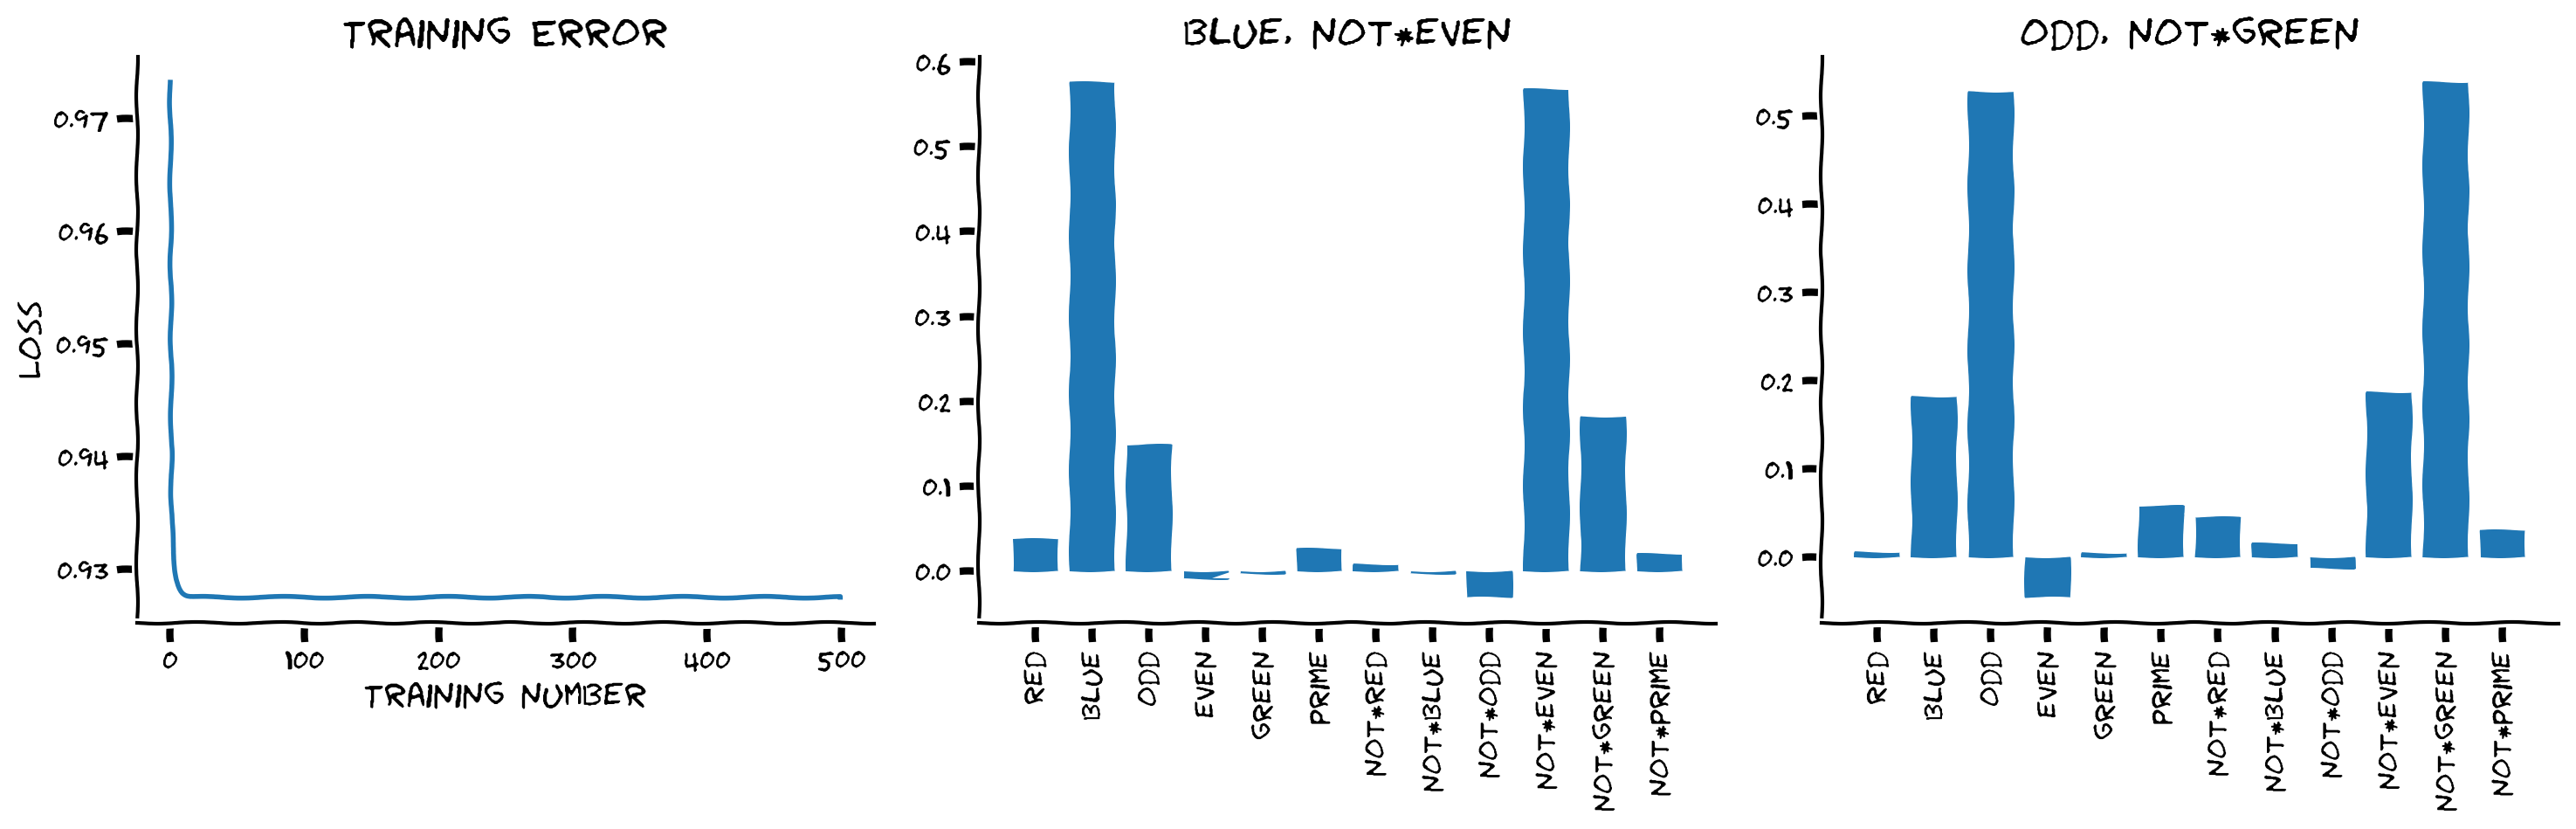

In [23]:
plt.figure(figsize=(15,5))
plot_training_and_choice(losses, sims, ant_names, cons_names, action_names)

Let's see what happens when we test it on a new rule it hasn't seen before. This time, we will use the rule that $\text{red} \implies \text{prime}$. Your task is to complete the new rule in the cell below and observe the results.

In [24]:
###################################################################
## Fill out the following then remove
#raise NotImplementedError("Student exercise: complete new rule and predict for it.")
###################################################################

new_rule = (vocab['ant'] * vocab["red"] + vocab['relation'] * vocab['implies'] + vocab['cons'] * vocab['prime']).normalize()

#apply transform on new rule to test the generalization of the transform
a_hat = sspspace.SSP(transform) * new_rule

new_sims = action_space @ a_hat.T
y_hat = softmax(new_sims)

[*Click for solution*](https://github.com/neuromatch/NeuroAI_Course/tree/main/tutorials/W2D2_NeuroSymbolicMethods/solutions/W2D2_Tutorial2_Solution_4dc054a5.py)



/usr/local/lib/python3.10/dist-packages/IPython/core/events.py:89: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  func(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


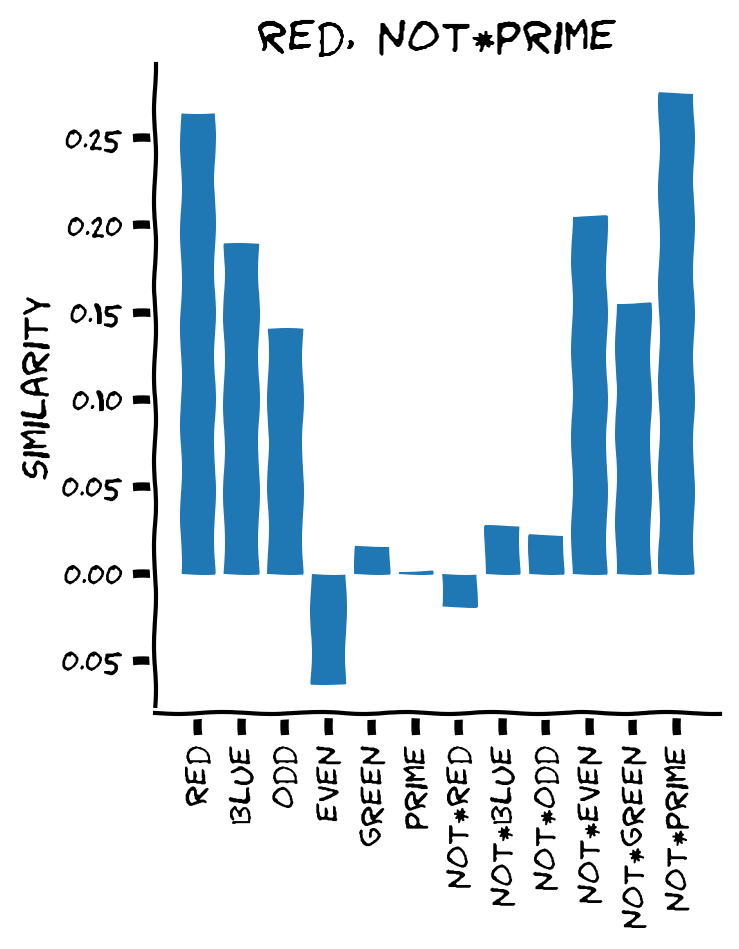

In [25]:
plt.figure(figsize=(7,5))
plot_choice([new_sims], ["red"], ["prime"], action_names)

Let's compare how a standard MLP that isn't aware of the structure in the representation performs. Here, features are going to be the rules and output - solutions. Complete the code below.

In [26]:
###################################################################
## Fill out the following then remove
#raise NotImplementedError("Student exercise: complete MLP training.")
###################################################################

#features - rules
X_train = np.array(rules).squeeze()

#output - a* for each rule
y_train = np.array([
    (vocab[ant_names[0]] + vocab['not']*vocab[cons_names[0]]).normalize(),
    (vocab[ant_names[1]] + vocab['not']*vocab[cons_names[1]]).normalize(),
]).squeeze()

regr = MLPRegressor(random_state=1, hidden_layer_sizes=(1024,1024), max_iter=1000).fit(X_train, y_train)

a_mlp = regr.predict(new_rule)

mlp_sims = action_space @ a_mlp.T

[*Click for solution*](https://github.com/neuromatch/NeuroAI_Course/tree/main/tutorials/W2D2_NeuroSymbolicMethods/solutions/W2D2_Tutorial2_Solution_35636d15.py)



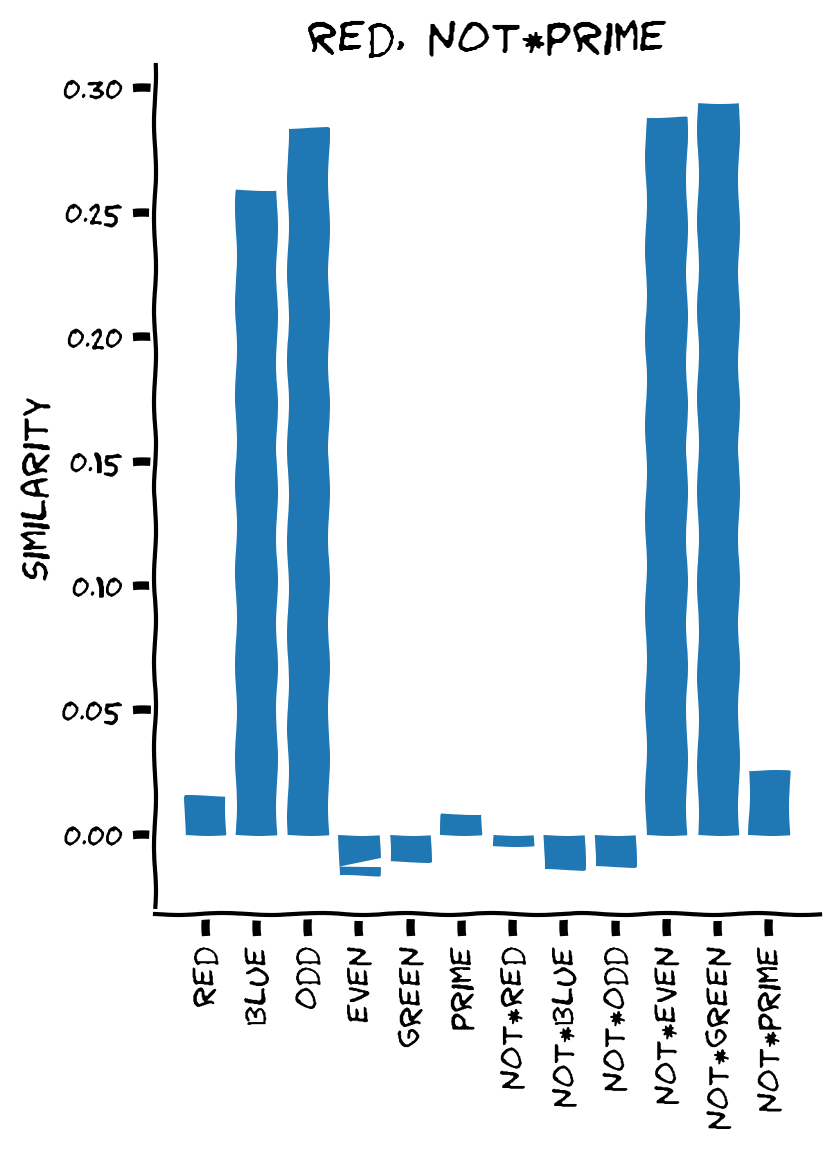

In [27]:
plot_choice([mlp_sims], ["red"], ["prime"], action_names)

As you can see, this model, even though it is a more expressive neural network, simply learns to predict the values it had seen before when presented with a novel stimulus.

In [ ]:
# @title Submit your feedback
content_review(f"{feedback_prefix}_wason_card_task")

In [ ]:
# @title Video 4: Wason Card Task Outro

from ipywidgets import widgets
from IPython.display import YouTubeVideo
from IPython.display import IFrame
from IPython.display import display

class PlayVideo(IFrame):
  def __init__(self, id, source, page=1, width=400, height=300, **kwargs):
    self.id = id
    if source == 'Bilibili':
      src = f'https://player.bilibili.com/player.html?bvid={id}&page={page}'
    elif source == 'Osf':
      src = f'https://mfr.ca-1.osf.io/render?url=https://osf.io/download/{id}/?direct%26mode=render'
    super(PlayVideo, self).__init__(src, width, height, **kwargs)

def display_videos(video_ids, W=400, H=300, fs=1):
  tab_contents = []
  for i, video_id in enumerate(video_ids):
    out = widgets.Output()
    with out:
      if video_ids[i][0] == 'Youtube':
        video = YouTubeVideo(id=video_ids[i][1], width=W,
                             height=H, fs=fs, rel=0)
        print(f'Video available at https://youtube.com/watch?v={video.id}')
      else:
        video = PlayVideo(id=video_ids[i][1], source=video_ids[i][0], width=W,
                          height=H, fs=fs, autoplay=False)
        if video_ids[i][0] == 'Bilibili':
          print(f'Video available at https://www.bilibili.com/video/{video.id}')
        elif video_ids[i][0] == 'Osf':
          print(f'Video available at https://osf.io/{video.id}')
      display(video)
    tab_contents.append(out)
  return tab_contents

video_ids = [('Youtube', '_77GHH8gfvk'), ('Bilibili', 'BV1rM4m1U7M3')]
tab_contents = display_videos(video_ids, W=854, H=480)
tabs = widgets.Tab()
tabs.children = tab_contents
for i in range(len(tab_contents)):
  tabs.set_title(i, video_ids[i][0])
display(tabs)

In [ ]:
# @title Submit your feedback
content_review(f"{feedback_prefix}_wason_card_task_outro")

---
# Summary

*Estimated timing of tutorial: 45 minutes*

In this tutorial, we observed three scenarios where we used the basic operations to solve different analogies and engage in structured learning. The next final tutorial will show us how to use structure to impose inductive biases and how to use continuous representations to represent mixtures of discrete and continuous objects.